<a href="https://colab.research.google.com/github/tynguyen/ML_ipython_worksheets/blob/main/K_Nearest_Neighbors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CIS 519 
## Week 2, Worksheet 0
# **K Nearest Neighbors (KNN)** 

- **Content Creator:** Ty Nguyen
- **Content Reviewers:** Halley Young, Kyle Vedder

The objective of this notebook is to walk through a working example of the K Nearest Neighbors (KNN) classification algorithm for the task of 
handwritten digit classification. The handwritten digits denote number 0-9. We will be using the famous MNIST dataset here. 



In [ ]:
# Install packages if necessary
# !python -m pip install scikit-learn

##Import Libraries

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.datasets import load_digits
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np
import cv2
import plotly.graph_objects as go
import seaborn as sns
import matplotlib as mpl 
# Some simple settings to make nice figures
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) # y axis's label size
mpl.rc('font', size=24) # Fig's title size 
mpl.rc('legend', fontsize=14) # Legend's fontsize 
mpl.rc('pdf', fonttype=42) # To avoid font-type-3 issue when importing figures as pdf for paper publication 
mpl.rc('font', family={'Times','monospace','sans-serif','monospace'}) # To avoid font-type-3 issue when importing figures as pdf for paper publication 

## Dataset

We will start by loading the MNIST dataset from sklearn and then create training, validation, and testing data.


In [84]:
# load the MNIST digits dataset
mnist = load_digits()
"""
**Data Set Characteristics:**
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998
"""

# take the MNIST data and construct the training and testing split, using 75% of the
# data for training and 25% for testing

X_train, X_test, y_train, y_test = train_test_split(np.array(mnist.data),
mnist.target, test_size=0.25, random_state=0)

# now, let's take 10% of the training data and use that for validation

(X_train, X_val, y_train, y_val) = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# show the sizes of each data split

print("training data points: {}".format(len(y_train)))
print("validation data points: {}".format(len(y_val)))
print("testing data points: {}".format(len(y_test)))
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Learn more about this data\n: {mnist['DESCR']}")

training data points: 1212
validation data points: 135
testing data points: 450
Shape of X_train: (1212, 64)
Shape of y_train: (1212,)
Learn more about this data
: .. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed t

## Data Visualization
One of the important steps in machine learning & data analysis is to understand the data. Besides the meaning and the range of the value of each attribute in the data, this step often involves data visualization.  

### Data Distributions
Let's plot out the histogram of the data which are basically gray images with intensity values ranging from 0 -> 16 (from data description). 

**Don't blindly trust the data description. It's not uncommon to have noisy/incorrect data**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



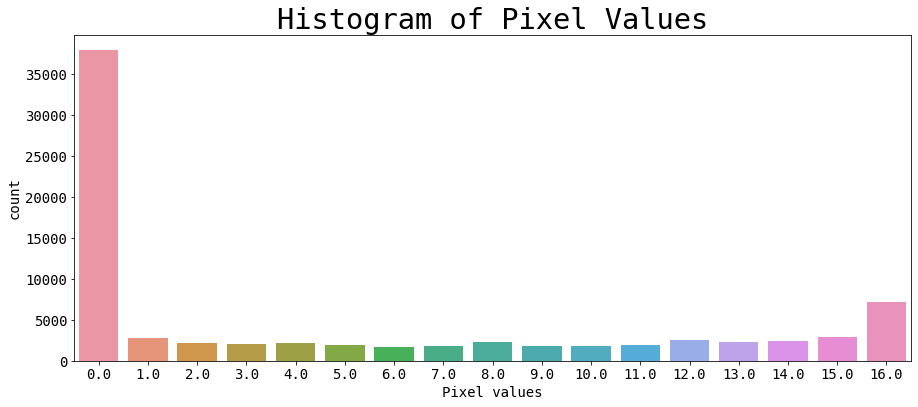

In [26]:
plt.figure(figsize=(15,6))
sns.countplot(X_train.flatten()) #  convert N x 64 => (N*64,)
plt.xlabel('Pixel values')
plt.title('Histogram of Pixel Values')
plt.show()


### Based on this histogram, we're pretty sure that the given data are consistent with what's described!

### Class Distribution
It's also very important to know the distribution of object classes in the dataset to handle a potential class imbalance problem. Class imbanlance problem is a critical issue when some object class has a dominant occurrences in the dataset, causing the trained model to be heavily trained on these classes while having less emphases on the others. 

In practice, this issue, if happens, can be addressed using different methods such as using a weighted loss, and/or resampling.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



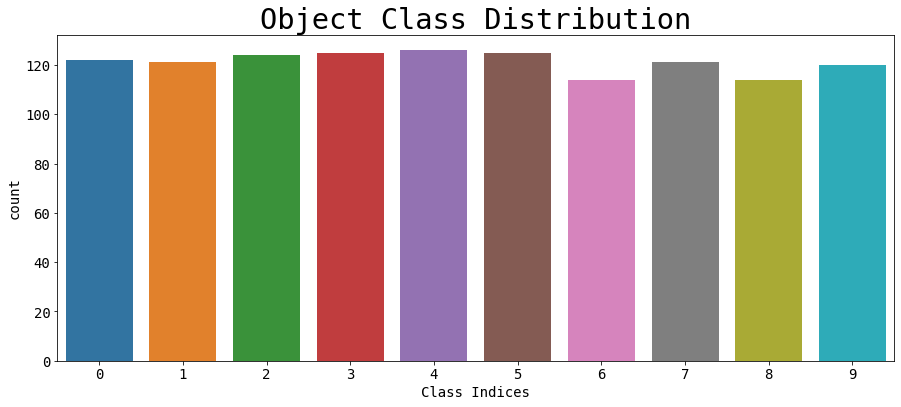

In [36]:
# We will plot out the histogram of the labels
plt.figure(figsize=(15,6))
sns.countplot(y_train)
plt.xlabel('Class Indices')
plt.title('Object Class Distribution')
plt.show()


## It's great that this dataset is already well balanced so it should be good to go.

### Data Point Visualization
Let's plot out a single data point which is basically a gray image with intensity value range from 0 -> 16

In [73]:
labels_list = np.zeros(10)
imgs_list   = np.zeros([10, 8, 8], dtype=np.uint8)
for i in range(len(y_train)):
  if labels_list.sum() == 10:
    break 
  label = int(y_train[i])
  labels_list[label] = 1
  imgs_list[label] = X_train[i].reshape([8,8])

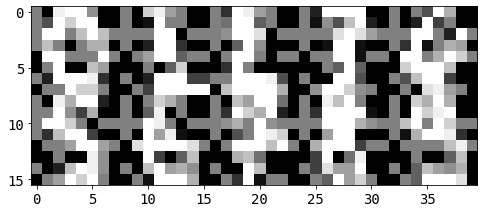

In [75]:
def gallery(array, ncols=5):
    nindex, height, width = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols)
    result = (array.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    return result
result = gallery(imgs_list)
plt.figure(figsize=(8,4))
plt.imshow(result, cmap='gray')
plt.show()
 
 

##Training

We will use sklearn's KNeighborsClassifier for training. Let us use different values of 'k' to gain some insights.

In [86]:
# initialize the values of k for our k-Nearest Neighbor classifier along with the
# list of accuracies for each value of k
k_values = range(1, 15, 1)
train_accuracies = []
valid_accuracies = []
# loop over various values of `k` for the k-Nearest Neighbor classifier

for k in k_values:
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train, y_train)
  score = model.score(X_val, y_val)
  valid_accuracies.append(score)

  score = model.score(X_train, y_train)
  train_accuracies.append(score)     

## Learning Curve

Finally, we will plot how different k values fare.

In [87]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = list(k_values), 
                        y = valid_accuracies,
                        mode='lines',
                        name='Validation Accuracy'))
fig.add_trace(go.Scatter(x = list(k_values), 
                        y = train_accuracies,
                        mode='lines',
                        name='Training Accuracy'))
fig.update_layout(title='Validation Accuracy v.s. K Values',
                  yaxis_title='Validation Accuracy',
                  xaxis_title='K Values'
                  )
fig.show()

- Can you explain the trend in the plot? 

- What do you think happens when k=1 or when k takes larger values? Why do these trends occur?

- Which optimal value of k should be chosen?

## Evaluation
Retraining with our chosen value of k, we can reevaluate the selected classifier. 

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        37
           1       0.93      0.98      0.95        43
           2       1.00      0.95      0.98        44
           3       0.98      0.98      0.98        45
           4       1.00      0.97      0.99        38
           5       0.98      0.98      0.98        48
           6       0.96      1.00      0.98        52
           7       0.94      1.00      0.97        48
           8       0.98      0.88      0.92        48
           9       0.98      0.98      0.98        47

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450

Predicted digit :  3
Predicted digit :  8
Predicted digit :  8
Predicted digit :  8
Predicted digit :  2


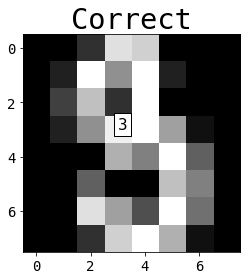

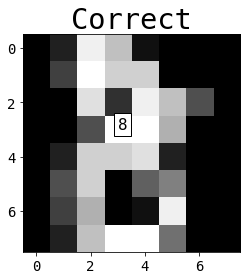

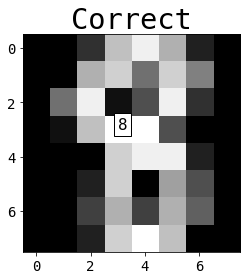

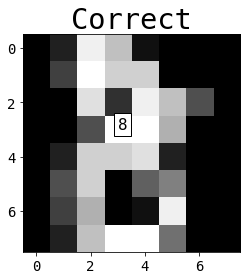

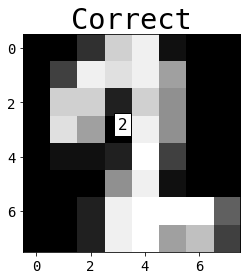

In [93]:
# re-train our classifier using  k = 5 and predict the labels of the test data
k = 12
model = KNeighborsClassifier(n_neighbors=k_values[k])
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# show a final classification report demonstrating the accuracy of the classifier
# for each of the digits

print("EVALUATION ON TESTING DATA")
print(classification_report(y_test, predictions))

# displaying results for a few digits
for i in np.random.randint(0, high=len(y_test), size=(5,)):
  # grab the image and classify it
  image = X_test[i]
  prediction = model.predict([image])[0]
  
  # show the prediction
  imgdata = np.array(image, dtype='float')
  pixels = imgdata.reshape((8,8))
  plt.figure()
  plt.imshow(pixels,cmap='gray')
  plt.annotate(prediction,(3,3),bbox={'facecolor':'white'},fontsize=16)
  # show correct or wrong
  title = 'Correct' if prediction == y_test[i] else 'wrong!'
  plt.title(title)
  print("Predicted digit : ",prediction)
  plt.show()